In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib_inline.backend_inline import set_matplotlib_formats

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, log_loss

### 도메인 테이블 다운

In [37]:
from google.cloud import bigquery
import pandas as pd


from google.cloud import bigquery
from google.oauth2 import service_account

key_path = "/Users/t2023-m0052/Desktop/kids/sodium-primer-471002-n4-82c44c68a51f.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)


# 쿼리 작성
query = """
SELECT *
FROM `sodium-primer-471002-n4.test_ad_list.plus_domain1`
"""

# 쿼리 실행 후 DataFrame으로 변환
df = client.query(query).to_dataframe()

print(df.head())


  ml_generate_text_llm_result ml_generate_text_rai_result  \
0                        금융\n                        None   
1                        None                        None   
2                        None                        None   
3                        게임\n                        None   
4                        생활\n                        None   

                             ml_generate_text_status  row_id  ads_idx  \
0  A retryable error occurred: GENERATE_TEXT reac...  153088   154946   
1  A retryable error occurred: GENERATE_TEXT reac...   11190    12911   
2  A retryable error occurred: GENERATE_TEXT reac...   14056    15811   
3                                                       4216     5859   
4                                                       9825    11508   

     ads_code  aff_idx  adv_idx  ads_type  ads_category  ... ads_age_min  \
0  KoM69LPFUB        8       50         3             7  ...           0   
1  YaqdYngnM2        7      228         1 

In [38]:
df1 = df.drop(['prompt', 'result', 'ml_generate_text_rai_result', 'ml_generate_text_status'], axis = 1)
# df.to_csv('광고도메인리스트_1년치.csv')

In [39]:
df1.rename(columns={'ml_generate_text_llm_result':'domain'}, inplace=True)

In [40]:
ALLOWED = [
    "게임","뷰티","커머스","의료/건강","금융","미디어/컨텐츠","식음료","생활",
    "채용","운세","식당/카페","운동/스포츠","교육","비영리/공공","기타"
]

PATTERNS = [
    (r'\b게임\b', "게임"),
    (r'\b뷰티\b', "뷰티"),
    (r'\b커머스\b', "커머스"),
    (r'의료\s*/?\s*건강', "의료/건강"),
    (r'\b금융\b', "금융"),
    (r'미디어\s*/?\s*[컨콘]텐츠|미디어콘텐츠', "미디어/컨텐츠"),
    (r'\b식음료\b', "식음료"),
    (r'\b생활\b', "생활"),
    (r'\b채용\b', "채용"),
    (r'\b운세\b', "운세"),
    (r'식당\s*/?\s*카페|식당카페', "식당/카페"),
    (r'운동\s*/?\s*스포츠|운동스포츠', "운동/스포츠"),
    (r'\b교육\b', "교육"),
    (r'비영리\s*/?\s*공공', "비영리/공공"),
    (r'\b기타\b', "기타"),
]

def normalize_domain(text: str) -> str:
    if pd.isna(text):
        return "기타"
    s = str(text)

    # 1) JSON 형태면 값만 추출
    m = re.search(r'"domain"\s*:\s*"([^"]+)"', s)
    if m:
        s = m.group(1)

    # 2) 포매팅/개행 제거
    s = re.sub(r'(\\n|[\r\n])+', ' ', s)           # 개행 제거
    s = re.sub(r'[`"*#]+', '', s)                 # 서식문자 제거
    s = s.strip()

    # 3) 허용 라벨 패턴 찾기
    for pat, lab in PATTERNS:
        if re.search(pat, s):
            return lab

    # 4) 라벨명이 정확히 쓰인 경우(여분 텍스트 동반)
    for lab in ALLOWED:
        if lab in s:
            return lab

    return "기타"

# 사용: df["result"] → 표준라벨
df1["domain"] = df1["domain"].apply(normalize_domain)

In [109]:
ad_list = pd.read_csv('/Users/t2023-m0052/Documents/GitHub/final_project/data/IVE_광고목록.csv')
ad_list = ad_list[['ads_idx', 'ads_name', 'ads_media_price']]
ad_list

/var/folders/4n/w27drm2j3_v05ss9qbg_6qsc0000gn/T/ipykernel_9295/918991609.py:1: DtypeWarning: Columns (12,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_list = pd.read_csv('/Users/t2023-m0052/Documents/GitHub/final_project/data/IVE_광고목록.csv')


KeyError: "['ads_media_price'] not in index"

In [110]:
ad_list.columns

Index(['ads_idx', 'ads_code', 'aff_idx', 'adv_idx', 'sch_idx', 'ads_type',
       'ads_category', 'ads_name', 'ads_search', 'ads_icon_img', 'ads_summary',
       'ads_guide', 'ads_limit', 'ads_payment', 'ads_save_way', 'ads_day_cap',
       'ads_sdate', 'ads_edate', 'ads_package', 'ads_sex_type', 'ads_age_min',
       'ads_age_max', 'ads_os_type', 'ads_contract_price', 'ads_reward_price',
       'ads_order', 'ads_rejoin_type', 'ads_require_adid', 'regdate', 'delyn'],
      dtype='object')

In [3]:
time_earn = pd.read_csv('/Users/t2023-m0052/Documents/GitHub/final_project/data/시간별적립보고서_1년치.csv')
time_earn.head()

,rpt_time_date,rpt_time_time,ads_idx,mda_idx,rpt_time_clk,rpt_time_turn,rpt_time_scost,rpt_time_acost,rpt_time_cost,rpt_time_earn,weekday,week_type
0,2024-07-27,0,4418,761,1,0,0,0,0,0,5,주말
1,2024-07-27,0,7377,213,1,0,0,0,0,0,5,주말
2,2024-07-27,0,7377,337,1,0,0,0,0,0,5,주말
3,2024-07-27,0,7377,496,1,1,230,230,180,180,5,주말
4,2024-07-27,0,7528,792,1,0,0,0,0,0,5,주말


In [43]:
one_y_ads_idx = time_earn.ads_idx.unique()
one_y_ads_idx

array([  4418,   7377,   7528, ...,  25092, 447467, 447049],
      shape=(234444,))

In [50]:
df[df.ads_idx.isin(one_y_ads_idx)]

,ml_generate_text_llm_result,ml_generate_text_rai_result,ml_generate_text_status,row_id,ads_idx,ads_code,aff_idx,adv_idx,ads_type,ads_category,...,ads_age_min,ads_age_max,ads_os_type,ads_contract_price,ads_reward_price,ads_order,ads_rejoin_type,regdate,prompt,result
0,금융\n,None,A retryable error occurred: GENERATE_TEXT reac...,153088,154946,KoM69LPFUB,8,50,3,7,...,0,100,7,800,640,2444400,NONE,2025-02-12 10:18:46,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:어센...,None
21,게임\n,None,,135518,137375,RBjgpLVOmR,71,910,3,8,...,0,100,7,200,150,2431500,NONE,2025-01-10 18:48:52,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:DK...,게임\n
23,게임\n,None,,427141,429013,TUSVjcBYtK,76,1355,3,5,...,0,100,2,9600,7200,2460500,NONE,2025-07-11 16:23:32,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:인생...,게임\n
31,게임\n,None,,161321,163182,OLNpNxxGJm,76,1355,3,5,...,0,100,2,4480,3360,2451800,NONE,2025-02-26 17:05:49,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:고블...,게임\n
34,게임\n,None,,161392,163254,r78MSmvuQk,76,1355,3,5,...,0,100,1,1440,1080,2450800,NONE,2025-02-26 17:57:33,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:Sa...,게임\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445032,생활\n,None,,430241,432114,BGgySZ2YBQ,86,1655,3,4,...,0,100,7,18,12,1369551,ADS_CODE_DAILY_UPDATE,2025-07-18 22:49:41,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:평택...,생활\n
445033,식당/카페\n,None,,441740,443617,nwmc3S9aN6,86,1655,3,4,...,0,100,7,18,12,1369936,ADS_CODE_DAILY_UPDATE,2025-08-12 09:52:10,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:서빙...,식당/카페\n
445035,None,None,A retryable error occurred: GENERATE_TEXT reac...,441322,443199,wzRihejZCx,86,1655,3,4,...,0,100,7,18,12,1369869,ADS_CODE_DAILY_UPDATE,2025-08-11 00:57:46,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:스팀...,None
445036,미디어/컨텐츠\n,None,,429473,431346,t6Z32D0ncq,86,1655,3,4,...,0,100,7,18,12,1369551,ADS_CODE_DAILY_UPDATE,2025-07-18 00:11:38,다음 광고 정보를 보고 가장 적합한 도메인을 하나만 선택해주세요.\n광고 이름:정답...,미디어/컨텐츠\n


In [44]:
df1 = df1[df1.ads_idx.isin(one_y_ads_idx)]

In [47]:
df1.shape

(233408, 23)

In [52]:
len(one_y_ads_idx) - df1.shape[0]

1036

In [ ]:
df1[df1.domain]

,domain,row_id,ads_idx,ads_code,aff_idx,adv_idx,ads_type,ads_category,ads_name,ads_icon_img,...,ads_sdate,ads_edate,ads_age_min,ads_age_max,ads_os_type,ads_contract_price,ads_reward_price,ads_order,ads_rejoin_type,regdate


In [ ]:
df1.to_csv('광고도메인리스트_1년치.csv', index = False)

In [2]:
domain_list = pd.read_csv('광고도메인리스트_1년치.csv')
domain_list.head()

,Unnamed: 0,domain,row_id,ads_idx,ads_code,aff_idx,adv_idx,ads_type,ads_category,ads_name,...,ads_sdate,ads_edate,ads_age_min,ads_age_max,ads_os_type,ads_contract_price,ads_reward_price,ads_order,ads_rejoin_type,regdate
0,0,금융,153088,154946,KoM69LPFUB,8,50,3,7,어센틱금융그룹 내보험조회,...,2025-02-12 10:00:00,2029-11-29 00:00:00,0,100,7,800,640,2444400,NONE,2025-02-12 10:18:46
1,21,게임,135518,137375,RBjgpLVOmR,71,910,3,8,DK모바일 리본 사전예약,...,2025-01-10 18:00:00,2030-01-01 00:00:00,0,100,7,200,150,2431500,NONE,2025-01-10 18:48:52
2,23,게임,427141,429013,TUSVjcBYtK,76,1355,3,5,인생존망겜(레벨 67 달성),...,2025-07-11 16:23:32,9999-12-31 23:59:59,0,100,2,9600,7200,2460500,NONE,2025-07-11 16:23:32
3,31,게임,161321,163182,OLNpNxxGJm,76,1355,3,5,고블린 우드: 타이쿤 유휴 심,...,2025-02-27 16:00:00,9999-12-31 23:59:59,0,100,2,4480,3360,2451800,NONE,2025-02-26 17:05:49
4,34,게임,161392,163254,r78MSmvuQk,76,1355,3,5,Save the Pets,...,2025-02-27 16:00:00,2031-01-03 00:00:00,0,100,1,1440,1080,2450800,NONE,2025-02-26 17:57:33


In [7]:
! pip install catboost

  Using cached catboost-1.2.8-cp311-cp311-macosx_11_0_universal2.whl.metadata (1.4 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
Using cached catboost-1.2.8-cp311-cp311-macosx_11_0_universal2.whl (27.8 MB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 7.6 MB/s eta 0:00:00a 0:00:01 MB 7.0 MB/s eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.3/407.3 kB 4.7 MB/s eta 0:00:0000:0100:01


In [38]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error

### train, test 나누기

In [5]:
# 유저 확인
part_earn = pd.read_csv('/Users/t2023-m0052/Documents/GitHub/final_project/data/참여적립조인.csv')
part_earn.head()

,Unnamed: 0,click_key,ads_idx,dvc_idx,mda_idx,pub_sub_rel_id,contract_price,media_price,click_day,click_time,...,network,user_ip,rwd_idx,ads_code,advid,adv_cost,earn_cost,regdate,ctit,conversion
0,0,000000d54b9faad47ee99d6cd3cf53894dd4baa5,313780,61906528,539,144350110,6000,4500,2025-08-17,21,...,0,16.184.28.219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,000002b4d92f7648b455877c2676452efcd22a09,412426,34422806,58,46032732,180,170,2025-07-26,2,...,NaN,35.78.117.76,238313226.0,yuRe4YoPuZ,40ceb01c-9b60-4452-bacd-0e061fb18ab4,180.0,170.0,2025-07-26 02:19:21,57.0,1
2,2,0000057e97361ff3d0263aaecee34cfaa3ba30fb,443660,38366075,808,1,170,120,2025-08-12,18,...,WIFI,39.7.55.192,239017177.0,WuIp8HKmt9,73793f44-a471-4351-ae1c-d09accaf223a,170.0,120.0,2025-08-12 18:19:21,82.0,1
3,3,00000607f60139015da3ee1dd5499db3faa100dc,360192,61894110,539,144350110,6000,4500,2025-08-17,3,...,0,211.252.100.157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,0000066bc25d4a6d147c27326cf972a4de88024e,372307,61956954,539,144350110,15600,11700,2025-08-18,8,...,0,3.38.148.211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [6]:
cl_part_earn = part_earn.drop(['Unnamed: 0', 'click_key', 'regdate'], axis=1)
cl_part_earn.head()

,ads_idx,dvc_idx,mda_idx,pub_sub_rel_id,contract_price,media_price,click_day,click_time,click_date,exp_day,network,user_ip,rwd_idx,ads_code,advid,adv_cost,earn_cost,ctit,conversion
0,313780,61906528,539,144350110,6000,4500,2025-08-17,21,2025-08-17 21:07:37,2025-09-16,0,16.184.28.219,NaN,NaN,NaN,NaN,NaN,NaN,0
1,412426,34422806,58,46032732,180,170,2025-07-26,2,2025-07-26 02:18:24,2025-08-25,NaN,35.78.117.76,238313226.0,yuRe4YoPuZ,40ceb01c-9b60-4452-bacd-0e061fb18ab4,180.0,170.0,57.0,1
2,443660,38366075,808,1,170,120,2025-08-12,18,2025-08-12 18:17:59,2025-09-11,WIFI,39.7.55.192,239017177.0,WuIp8HKmt9,73793f44-a471-4351-ae1c-d09accaf223a,170.0,120.0,82.0,1
3,360192,61894110,539,144350110,6000,4500,2025-08-17,3,2025-08-17 03:35:02,2025-09-16,0,211.252.100.157,NaN,NaN,NaN,NaN,NaN,NaN,0
4,372307,61956954,539,144350110,15600,11700,2025-08-18,8,2025-08-18 08:01:26,2025-09-17,0,3.38.148.211,NaN,NaN,NaN,NaN,NaN,NaN,0


In [7]:
cl_part_earn.columns

Index(['ads_idx', 'dvc_idx', 'mda_idx', 'pub_sub_rel_id', 'contract_price',
       'media_price', 'click_day', 'click_time', 'click_date', 'exp_day',
       'network', 'user_ip', 'rwd_idx', 'ads_code', 'advid', 'adv_cost',
       'earn_cost', 'ctit', 'conversion'],
      dtype='object')

In [8]:
domain = pd.read_csv("/Users/t2023-m0052/Documents/GitHub/final_project/data/광고도메인리스트.csv")
domain.head()

,Unnamed: 0,ads_idx,ads_code,aff_idx,adv_idx,ads_type,ads_category,ads_name,ads_icon_img,ads_summary,...,ads_edate,ads_age_min,ads_age_max,ads_os_type,ads_contract_price,ads_reward_price,ads_order,ads_rejoin_type,regdate,domain
0,0,6508,3u4lOKJAek,13,335,3,10,스마트피싱보호,https://seimg.pincrux.com/icon/1551770735.png,"[상품소개]\n알면 피하고, 모르면 당하는 보이스피싱\n나와 소중한 가족을 안전하게...",...,9999-12-31 00:00:00,0,100,7,1400,1100,2381500,NONE,2020-04-23 17:53:01 UTC,금융
1,1,6985,SijDrtH4GV,13,335,3,7,DB손해보험 다이렉트,https://seimg.pincrux.com/icon/1575337232.jpg,[참여방법]\n- 빠르고 간편한 DB손해보험 다이렉트에서\n- 내 차 보험료를 지금...,...,9999-06-06 00:00:00,0,100,7,2700,2300,1201938,NONE,2020-06-30 15:22:59 UTC,금융
2,2,8327,k1RZftVHoW,13,335,3,10,파일썬,https://static.i-screen.kr/img/ad/icon/aff_13_...,[참여 방법]\n1. 광고 참여 버튼 터치하여 이벤트 페이지로 이동\n2. 이벤트 ...,...,9999-12-31 23:59:00,0,100,7,3200,2420,1673458,NONE,2020-11-10 11:21:43 UTC,미디어/컨텐츠
3,3,9264,EGZcaVOtlc,23,220,3,10,하나 가득담은 운전자보험가입,https://i.imgur.com/kaWiYyT.png,하나손해보험 다이렉트 운전자보험 가입시\n\n01.참여방법\n1) 계산하기 페이지를...,...,9999-12-31 23:59:59,0,100,7,11000,8250,2372800,NONE,2020-11-30 15:16:45 UTC,금융
4,4,9716,NwZZq45Kgb,6,10,3,8,베이비러브 참여 신청,https://nextapps-nas.aws.appang.kr/icon/SDl2uC...,[참여방법]\n- 페이지 이동 > 베이버러브 참여신청 완료\n- 25-55세 SKT...,...,2029-11-29 00:00:00,25,55,2,600,480,2699900,NONE,2021-01-11 16:11:27 UTC,생활


In [9]:
cl_domain = domain.drop(['Unnamed: 0','ads_icon_img', 'ads_summary'# , #'ads_sdate', 
                         #'ads_age_min', 'ads_age_max'
                         ], axis = 1)

In [10]:
r_df = cl_part_earn.merge(cl_domain, on = ['ads_idx'], how='left')
r_df.columns

Index(['ads_idx', 'dvc_idx', 'mda_idx', 'pub_sub_rel_id', 'contract_price',
       'media_price', 'click_day', 'click_time', 'click_date', 'exp_day',
       'network', 'user_ip', 'rwd_idx', 'ads_code_x', 'advid', 'adv_cost',
       'earn_cost', 'ctit', 'conversion', 'ads_code_y', 'aff_idx', 'adv_idx',
       'ads_type', 'ads_category', 'ads_name', 'ads_save_way', 'ads_day_cap',
       'ads_sdate', 'ads_edate', 'ads_age_min', 'ads_age_max', 'ads_os_type',
       'ads_contract_price', 'ads_reward_price', 'ads_order',
       'ads_rejoin_type', 'regdate', 'domain'],
      dtype='object')

In [11]:
r_df.drop(['ads_code_x'], axis = 1, inplace=True)
r_df.rename(columns={"ads_code_y":"ads_code"}, inplace=True)
r_df.columns

Index(['ads_idx', 'dvc_idx', 'mda_idx', 'pub_sub_rel_id', 'contract_price',
       'media_price', 'click_day', 'click_time', 'click_date', 'exp_day',
       'network', 'user_ip', 'rwd_idx', 'advid', 'adv_cost', 'earn_cost',
       'ctit', 'conversion', 'ads_code', 'aff_idx', 'adv_idx', 'ads_type',
       'ads_category', 'ads_name', 'ads_save_way', 'ads_day_cap', 'ads_sdate',
       'ads_edate', 'ads_age_min', 'ads_age_max', 'ads_os_type',
       'ads_contract_price', 'ads_reward_price', 'ads_order',
       'ads_rejoin_type', 'regdate', 'domain'],
      dtype='object')

In [12]:
r_df.isnull().sum()

ads_idx                      0
dvc_idx                      0
mda_idx                      0
pub_sub_rel_id               0
contract_price               0
media_price                  0
click_day                    0
click_time                   0
click_date                   0
exp_day                      0
network                2501362
user_ip                      9
rwd_idx               15379915
advid                 15387086
adv_cost              15379915
earn_cost             15379915
ctit                  15379915
conversion                   0
ads_code                     0
aff_idx                      0
adv_idx                      0
ads_type                     0
ads_category                 0
ads_name                     0
ads_save_way                 0
ads_day_cap                  0
ads_sdate                    0
ads_edate                    0
ads_age_min                  0
ads_age_max                  0
ads_os_type                  0
ads_contract_price           0
ads_rewa

In [13]:
r_df['ive_earn'] = r_df['contract_price'] - r_df['media_price']

In [14]:
import datetime
r_df['click_day'] = pd.to_datetime(r_df['click_day'])
r_df['weekday'] = r_df['click_day'].dt.weekday

In [15]:
r_df.columns

Index(['ads_idx', 'dvc_idx', 'mda_idx', 'pub_sub_rel_id', 'contract_price',
       'media_price', 'click_day', 'click_time', 'click_date', 'exp_day',
       'network', 'user_ip', 'rwd_idx', 'advid', 'adv_cost', 'earn_cost',
       'ctit', 'conversion', 'ads_code', 'aff_idx', 'adv_idx', 'ads_type',
       'ads_category', 'ads_name', 'ads_save_way', 'ads_day_cap', 'ads_sdate',
       'ads_edate', 'ads_age_min', 'ads_age_max', 'ads_os_type',
       'ads_contract_price', 'ads_reward_price', 'ads_order',
       'ads_rejoin_type', 'regdate', 'domain', 'ive_earn', 'weekday'],
      dtype='object')

In [16]:
r_df

,ads_idx,dvc_idx,mda_idx,pub_sub_rel_id,contract_price,media_price,click_day,click_time,click_date,exp_day,...,ads_age_max,ads_os_type,ads_contract_price,ads_reward_price,ads_order,ads_rejoin_type,regdate,domain,ive_earn,weekday
0,313780,61906528,539,144350110,6000,4500,2025-08-17,21,2025-08-17 21:07:37,2025-09-16,...,100,2,6000,4500,2447700,NONE,2025-04-09 10:39:25 UTC,게임,1500,6
1,412426,34422806,58,46032732,180,170,2025-07-26,2,2025-07-26 02:18:24,2025-08-25,...,100,2,180,120,2749100,NONE,2025-07-02 15:10:22 UTC,게임,10,5
2,443660,38366075,808,1,170,120,2025-08-12,18,2025-08-12 18:17:59,2025-09-11,...,100,2,170,120,2758100,NONE,2025-08-12 11:17:14 UTC,생활,50,1
3,360192,61894110,539,144350110,6000,4500,2025-08-17,3,2025-08-17 03:35:02,2025-09-16,...,100,2,6000,4500,2449700,NONE,2025-05-08 10:47:13 UTC,게임,1500,6
4,372307,61956954,539,144350110,15600,11700,2025-08-18,8,2025-08-18 08:01:26,2025-09-17,...,100,2,15600,11700,2456300,NONE,2025-05-30 10:09:21 UTC,게임,3900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16854860,264409,37945741,539,144350110,5400,3800,2025-08-16,23,2025-08-16 23:57:32,2025-09-15,...,100,2,5400,3800,2447400,NONE,2025-04-03 16:20:42 UTC,게임,1600,5
16854861,369816,57367216,539,144350110,3600,2700,2025-08-18,15,2025-08-18 15:16:57,2025-09-17,...,100,2,3600,2700,2454600,NONE,2025-05-26 18:14:09 UTC,게임,900,0
16854862,444350,61242190,58,33306660,180,170,2025-08-20,1,2025-08-20 01:02:48,2025-09-19,...,100,2,180,120,2763600,NONE,2025-08-14 15:33:36 UTC,게임,10,2
16854863,360192,61903879,539,144350110,6000,4500,2025-08-15,12,2025-08-15 12:04:56,2025-09-14,...,100,2,6000,4500,2449700,NONE,2025-05-08 10:47:13 UTC,게임,1500,4


유저 속성: user_game_ratio, user_click_rate, os_type

매체 속성: mda_avg_reward, mda_game_ratio

광고 속성: ad_reward_price, ad_domain_game, ad_ctr, 요일-전환 잘 되는, 시간-전환 잘 되는
단가
correlation 확인
'click_time' = 'hour', 'weekday'
['ads_category', 'ads_contract_price', 'ads_os_type', 'hour', 'weekday', 'ive_earn']

In [27]:
r_df['dvc_idx'].value_counts()

dvc_idx
0           43368
61747080    21877
61515716     4820
61916606     4359
61900408     4255
            ...  
28931072        1
50914232        1
61394253        1
51546422        1
37184425        1
Name: count, Length: 992489, dtype: int64

In [ ]:
data = r_df[[, 'ads_category', 'ads_os_type', 'ive_earn', 'click_time', 'weekday', 'conversion']]

<Axes: >

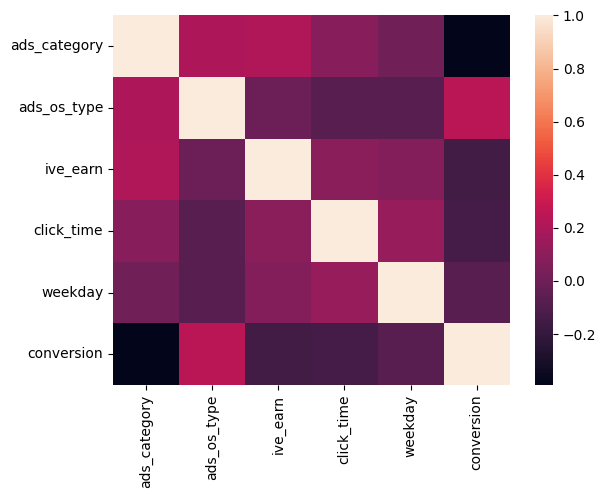

In [35]:
sns.heatmap(data.corr())

In [29]:
#독립/ 종속 변수 분리
X = data.drop(columns=['conversion'],axis=1) # .reset_index(drop=True)
y_true = data['conversion'] #.reset_index(drop=True)
print('전처리 완료:',X.shape,y_true.shape)
display(X.head(3))
print('----------------------------')

전처리 완료: (16854865, 5) (16854865,)


,ads_category,ads_os_type,ive_earn,click_time,weekday
0,5,2,1500,21,6
1,2,2,10,2,5
2,0,2,50,18,1


----------------------------


In [ ]:
r_df.groupby()

In [ ]:
#테스터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y_true,test_size = 0.2, shuffle=False) # st
print('데이터 분리 후 크기 확인 : ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

데이터 분리 후 크기 확인 :  (13483892, 5) (3370973, 5) (13483892,) (3370973,)


In [ ]:
#범주형 컬럼 변수 선언
cat_features = ['ads_category','ads_os_type', 'weekday']

model = CatBoostClassifier(
    iterations=300,       # 트리 개수
    depth=6,              # 트리 깊이
    learning_rate=0.1,    
    random_state=42,
    cat_features=cat_features,
    verbose=100           # 100번마다 로그 출력
)

#모델 생성 - 범주형 변수 옵션 설정 'cat_features'
# model = CatBoostClassifier(random_state=42,cat_features=cat_features)

#학습
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#평가
print('ac:', accuracy_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print("AUC :", roc_auc_score(y_test, y_pred))

0:	learn: 0.4716410	total: 10.5s	remaining: 52m 14s
100:	learn: 0.1119647	total: 12m 57s	remaining: 25m 31s
200:	learn: 0.1104924	total: 30m 42s	remaining: 15m 7s
299:	learn: 0.1099786	total: 39m 45s	remaining: 0us
ac: 0.9390944394986255
f1: 0.6450074608413893
recall: 0.6414152876930906
precision: 0.648640095702765
AUC : 0.8043066383199148


In [ ]:
# y_prob = 

array([0, 0, 0, ..., 0, 0, 0], shape=(3370973,))

### 매체사 추천

In [26]:
mr_df = time_earn.merge(domain_list, on = 'ads_idx', how = 'left')
mr_df.columns
# mr_df.drop(columns=['', ''])


Index(['rpt_time_date', 'rpt_time_time', 'ads_idx', 'mda_idx', 'rpt_time_clk',
       'rpt_time_turn', 'rpt_time_scost', 'rpt_time_acost', 'rpt_time_cost',
       'rpt_time_earn', 'weekday', 'week_type', 'Unnamed: 0', 'domain',
       'row_id', 'ads_code', 'aff_idx', 'adv_idx', 'ads_type', 'ads_category',
       'ads_name', 'ads_icon_img', 'ads_summary', 'ads_save_way',
       'ads_day_cap', 'ads_sdate', 'ads_edate', 'ads_age_min', 'ads_age_max',
       'ads_os_type', 'ads_contract_price', 'ads_reward_price', 'ads_order',
       'ads_rejoin_type', 'regdate'],
      dtype='object')

In [18]:
mr_df.value_counts('mda_idx')

mda_idx
563     1367732
371      537011
761      457132
270      422514
562      405634
         ...   
377           1
437           1
1023          1
609           1
244           1
Name: count, Length: 337, dtype: int64

In [19]:
mr_df[mr_df.domain.isna()].value_counts('mda_idx')

mda_idx
563     2597
562      476
371      468
270      360
22       269
634      224
761      166
854      101
817       61
54        57
539       39
645       38
246       30
667       30
790       28
281       25
1012      25
343       23
344       21
14        20
342       19
714       18
12        18
58        18
337       16
643       16
398       10
401        9
1013       9
482        8
480        7
655        7
290        7
1041       7
978        6
540        6
375        5
785        4
389        3
711        3
568        3
30         3
1018       2
73         2
630        2
442        1
294        1
481        1
772        1
1019       1
1037       1
564        1
1042       1
Name: count, dtype: int64

In [20]:
mr_df.isnull().sum() # 원본 6953146

rpt_time_date            0
rpt_time_time            0
ads_idx                  0
mda_idx                  0
rpt_time_clk             0
rpt_time_turn            0
rpt_time_scost           0
rpt_time_acost           0
rpt_time_cost            0
rpt_time_earn            0
weekday                  0
week_type                0
Unnamed: 0            5274
domain                5274
row_id                5274
ads_code              5274
aff_idx               5274
adv_idx               5274
ads_type              5274
ads_category          5274
ads_name              5274
ads_icon_img          5274
ads_summary           5274
ads_save_way          5274
ads_day_cap           5274
ads_sdate             5274
ads_edate             5274
ads_age_min           5274
ads_age_max           5274
ads_os_type           5274
ads_contract_price    5274
ads_reward_price      5274
ads_order             5274
ads_rejoin_type       5274
regdate               5274
dtype: int64

In [27]:
mr_df.drop(columns=['ads_type', 'row_id', 'ads_icon_img', 'ads_summary', 'Unnamed: 0'], axis = 1, inplace = True)

In [28]:
mr_df = mr_df.dropna(axis = 0)
mr_df.shape

(6947872, 30)

In [29]:
mr_df

,rpt_time_date,rpt_time_time,ads_idx,mda_idx,rpt_time_clk,rpt_time_turn,rpt_time_scost,rpt_time_acost,rpt_time_cost,rpt_time_earn,...,ads_sdate,ads_edate,ads_age_min,ads_age_max,ads_os_type,ads_contract_price,ads_reward_price,ads_order,ads_rejoin_type,regdate
0,2024-07-27,0,4418,761,1,0,0,0,0,0,...,2019-07-08 15:00:00,9999-12-31 00:00:00,0.0,100.0,7.0,22000.0,18700.0,1519426.0,NONE,2019-07-08 15:38:18
1,2024-07-27,0,7377,213,1,0,0,0,0,0,...,2020-08-18 11:00:00,2026-04-01 00:00:00,30.0,100.0,7.0,230.0,180.0,2408800.0,NONE,2020-08-18 11:22:47
2,2024-07-27,0,7377,337,1,0,0,0,0,0,...,2020-08-18 11:00:00,2026-04-01 00:00:00,30.0,100.0,7.0,230.0,180.0,2408800.0,NONE,2020-08-18 11:22:47
3,2024-07-27,0,7377,496,1,1,230,230,180,180,...,2020-08-18 11:00:00,2026-04-01 00:00:00,30.0,100.0,7.0,230.0,180.0,2408800.0,NONE,2020-08-18 11:22:47
4,2024-07-27,0,7528,792,1,0,0,0,0,0,...,2020-09-10 19:00:00,9999-12-31 00:00:00,0.0,100.0,7.0,230.0,180.0,2407100.0,NONE,2020-09-10 19:02:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953127,2025-08-29,11,445514,817,1,0,0,0,0,0,...,2025-08-21 10:00:00,2025-09-05 00:00:00,0.0,100.0,3.0,190.0,120.0,2763700.0,NONE,2025-08-20 11:50:37
6953128,2025-08-29,11,446544,761,2,0,0,0,0,0,...,2025-08-23 12:17:56,9999-12-31 23:59:59,0.0,100.0,7.0,28.0,20.0,1369916.0,NONE,2025-08-23 12:17:56
6953129,2025-08-29,11,446917,22,1,0,0,0,0,0,...,2025-08-25 11:00:00,2030-12-27 00:00:00,0.0,100.0,7.0,300.0,225.0,2764400.0,NONE,2025-08-25 11:18:35
6953130,2025-08-29,11,446917,270,1,0,0,0,0,0,...,2025-08-25 11:00:00,2030-12-27 00:00:00,0.0,100.0,7.0,300.0,225.0,2764400.0,NONE,2025-08-25 11:18:35


In [30]:
mr_df.columns

Index(['rpt_time_date', 'rpt_time_time', 'ads_idx', 'mda_idx', 'rpt_time_clk',
       'rpt_time_turn', 'rpt_time_scost', 'rpt_time_acost', 'rpt_time_cost',
       'rpt_time_earn', 'weekday', 'week_type', 'domain', 'ads_code',
       'aff_idx', 'adv_idx', 'ads_category', 'ads_name', 'ads_save_way',
       'ads_day_cap', 'ads_sdate', 'ads_edate', 'ads_age_min', 'ads_age_max',
       'ads_os_type', 'ads_contract_price', 'ads_reward_price', 'ads_order',
       'ads_rejoin_type', 'regdate'],
      dtype='object')

In [31]:
mr_df['ive_earn'] = mr_df.rpt_time_acost - mr_df.rpt_time_earn

In [34]:
mr_df.groupby('mda_idx')['rpt_time_earn'].agg(['mean', 'median'])

,mean,median
mda_idx,,
12,5276.420615,285.0
14,1345.691258,0.0
18,1130.812709,0.0
22,1154.881560,180.0
26,506.449246,170.0
...,...,...
1057,77.812500,0.0
1058,120.000000,120.0
1059,0.000000,0.0


In [35]:
mr_df['cvr'] = mr_df['rpt_time_turn'] / mr_df['rpt_time_clk']
       

In [54]:
mr_df['cvr'] = np.where(
    mr_df['rpt_time_clk'] == 0,
    0,  # 분모=0이면 CVR=0
    mr_df['rpt_time_turn'] / mr_df['rpt_time_clk']
)

# inf/-inf 제거
mr_df['cvr'].replace([np.inf, -np.inf], 0, inplace=True)

# 필요시 클리핑 (예: CVR은 확률값이므로 0~1 사이 제한 가능)
mr_df['cvr'] = mr_df['cvr'].clip(0, 1)

/var/folders/4n/w27drm2j3_v05ss9qbg_6qsc0000gn/T/ipykernel_81420/2192130516.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mr_df['cvr'].replace([np.inf, -np.inf], 0, inplace=True)


In [55]:
data = mr_df[['mda_idx', 'ads_idx', 'weekday', 'rpt_time_time', 'ive_earn', 'ads_category', 'ads_os_type', 'cvr']]

In [56]:
data.ads_category = data.ads_category.astype('int')
data['ads_os_type'] = data['ads_os_type'].astype('int')

/var/folders/4n/w27drm2j3_v05ss9qbg_6qsc0000gn/T/ipykernel_81420/2320438459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ads_category = data.ads_category.astype('int')
/var/folders/4n/w27drm2j3_v05ss9qbg_6qsc0000gn/T/ipykernel_81420/2320438459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ads_os_type'] = data['ads_os_type'].astype('int')


In [60]:
X.columns

Index(['weekday', 'rpt_time_time', 'ive_earn', 'ads_category', 'ads_os_type'], dtype='object')

In [57]:
X = data.drop(columns=['mda_idx', 'ads_idx', 'cvr'], axis=1)
y = data[['cvr']]

#테스터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, shuffle=False) # st
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size = 0.5, shuffle=False)
print('데이터 분리 후 크기 확인 : ',X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


데이터 분리 후 크기 확인 :  (5558297, 5) (694787, 5) (694788, 5) (5558297, 1) (694787, 1) (694788, 1)


In [58]:
#범주형 컬럼 변수 선언
cat_features = ['ads_category','ads_os_type', 'weekday']

model = CatBoostRegressor(
    iterations=300,          # 트리 개수 (기본 1000 → 너무 오래 걸림, 200~500 권장)
    depth=8,                 # 트리 깊이 (보통 6~10 사이, 깊어질수록 느려짐)
    learning_rate=0.1,       
    bootstrap_type='No',     # 샘플링 안 함 (CPU 속도 안정적)
    # subsample=1.0,           # 전체 데이터 사용
    random_state=42,
    verbose=100,
    task_type="CPU",         # 명시적으로 CPU 사용
    thread_count=-1          # CPU 코어 전부 활용
)


#학습
model.fit(X_train, y_train,
          eval_set=(X_val, y_val),
          early_stopping_rounds=50)
y_pred = model.predict(X_test)

#평가 2_score, root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error
print('rmse:', root_mean_squared_error(y_test, y_pred))
print('mse:', mean_squared_error(y_test, y_pred))
print('r2:', r2_score(y_test, y_pred))
print('mape:', mean_absolute_percentage_error(y_test, y_pred))
# print("AUC :", roc_auc_score(y_test, y_pred))

0:	learn: 0.3968637	test: 0.3879064	best: 0.3879064 (0)	total: 394ms	remaining: 1m 57s
100:	learn: 0.2041916	test: 0.2148415	best: 0.2148352 (96)	total: 26.7s	remaining: 52.7s
200:	learn: 0.2028870	test: 0.2140592	best: 0.2140585 (199)	total: 50.2s	remaining: 24.7s
299:	learn: 0.2021901	test: 0.2137822	best: 0.2137727 (286)	total: 1m 13s	remaining: 0us

bestTest = 0.2137727264
bestIteration = 286

Shrink model to first 287 iterations.
rmse: 0.2140525348255294
mse: 0.045818487665234484
r2: 0.7480101879318299
mape: 36716979618191.266


In [ ]:
# 1. 광고 단위로 예측된 CVR 얻기
mr_df['pred_cvr'] = model.predict(mr_df[['weekday', 'rpt_time_time', 'ive_earn', 'ads_category', 'ads_os_type']])

# 2. 매체사 단위 집계 (예: aff_idx가 매체사 ID라고 가정)
media_perf = mr_df.groupby('aff_idx').agg(
    avg_pred_cvr=('pred_cvr', 'mean'),
    ads_count=('ads_idx', 'nunique')
).reset_index()

# 3. 스코어 계산 (트래픽 가중치 반영 예시)
media_perf['score'] = media_perf['avg_pred_cvr'] * np.log1p(media_perf['ads_count'])

# 4. 추천 매체사 Top-N
top_media = media_perf.sort_values('score', ascending=False).head(5)
print(top_media[['mda_idx', 'avg_pred_cvr', 'score']])


    aff_idx  avg_pred_cvr     score
11     39.0      0.705120  7.207443
27     80.0      0.660895  6.506833
30     83.0      0.558907  6.439512
29     82.0      0.559212  6.003777
26     79.0      0.744753  5.511179


In [63]:
import pandas as pd

# 1. 광고 단위 예측 CVR 생성
mr_df['pred_cvr'] = model.predict(mr_df[['weekday', 'rpt_time_time', 'ive_earn', 'ads_category', 'ads_os_type']])

# 2. 매체사-광고 매핑 데이터 (예시)
# mr_df 안에 이미 aff_idx, ads_idx가 같이 들어 있다고 가정
recommend_base = mr_df[['mda_idx', 'ads_idx', 'pred_cvr', 'ads_day_cap', 'ads_category']]

# 3. 스코어 계산 (단순화 예시: pred_cvr + 광고집행 여력 반영)
recommend_base['score'] = recommend_base['pred_cvr'] #* (recommend_base['ads_day_cap'] > 0)

# 4. 매체사별 Top-N 광고 추천
N = 5
recommendations = (
    recommend_base
    .sort_values(['mda_idx', 'score'], ascending=[True, False])
    .groupby('mda_idx')
    .head(N)
    .reset_index(drop=True)
)

print(recommendations[['mda_idx', 'ads_idx', 'pred_cvr', 'score']])


/var/folders/4n/w27drm2j3_v05ss9qbg_6qsc0000gn/T/ipykernel_81420/3838884121.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommend_base['score'] = recommend_base['pred_cvr'] #* (recommend_base['ads_day_cap'] > 0)


      mda_idx  ads_idx  pred_cvr     score
0          12   134394  0.909970  0.909970
1          12    25342  0.908635  0.908635
2          12   146802  0.902082  0.902082
3          12    95852  0.901914  0.901914
4          12    95852  0.901690  0.901690
...       ...      ...       ...       ...
1599     1061   132773  0.909094  0.909094
1600     1061   132773  0.909046  0.909046
1601     1061   132773  0.907066  0.907066
1602     1061   132773  0.900766  0.900766
1603     1061   132773  0.899716  0.899716

[1604 rows x 4 columns]


In [59]:

data['y_pred'] = y_pred

ValueError: Length of values (694788) does not match length of index (6947872)

In [ ]:
# -----------------------
# 3. 추천 함수
# -----------------------
def recommend_topk_mda(df, k=3):
    """
    매체사별 Top-K 광고 추천
    """
    return (
        df.sort_values(['mda_id','y_pred'], ascending=[True, False])
          .groupby('mda_id')
          .head(k)
    )

# -----------------------
# 4. 평가 함수
# -----------------------
def hit_rate_at_k(df, k=3):
    topk = recommend_topk_mda(df, k)
    hits = topk.groupby('mda_id')['y'].max()  # 하나라도 맞으면 1
    return hits.mean()

def ndcg_at_k(df, k=3):
    def dcg(scores):
        return np.sum([
            (2**rel - 1) / np.log2(idx+2) 
            for idx, rel in enumerate(scores)
        ])
    ndcgs = []
    for _, group in df.groupby('mda_id'):
        ranked = group.sort_values('y_pred', ascending=False).head(k)
        dcg_val = dcg(ranked['y'].values)
        idcg_val = dcg(sorted(group['y'], reverse=True)[:k])
        ndcgs.append(dcg_val / idcg_val if idcg_val > 0 else 0.0)
    return np.mean(ndcgs)

def evaluate(df, k=3):
    auc = roc_auc_score(df['y'], df['y_pred'])
    logloss = log_loss(df['y'], df['y_pred'])
    hr = hit_rate_at_k(df, k)
    ndcg = ndcg_at_k(df, k)
    print(f"AUC: {auc:.4f}")
    print(f"LogLoss: {logloss:.4f}")
    print(f"HR@{k}: {hr:.4f}")
    print(f"NDCG@{k}: {ndcg:.4f}")

# -----------------------
# 5. 실행 예시
# -----------------------
evaluate(df, k=2)

topk_reco = recommend_topk_mda(df, k=2)
print(topk_reco[['mda_id','ad_id','y_pred']])

In [ ]:
def generate_recommendations(self, user_id, available_ads, user_info, top_k=10):
        """특정 유저에게 광고 추천"""
        recommendations = []
        
        # 각 광고에 대해 전환 확률 계산
        for ad in available_ads:
            # 유저-광고 조합 데이터 생성
            user_ad_data = {
                'user_id': user_id,
                'ad_code': ad['ad_code'],
                'ad_category': ad['category'],
                'reward_amount': ad['reward_amount'],
                'is_replayable': ad.get('is_replayable', 1),
                'remaining_budget_ratio': ad.get('remaining_budget_ratio', 1.0),
                
                # 유저 정보
                'device_type': user_info.get('device_type', 'android'),
                'user_total_clicks': user_info.get('total_clicks', 0),
                'user_past_conversions': user_info.get('past_conversions', 0),
                'user_category_preference': user_info.get('category_preferences', {}).get(ad['category'], 0.5),
                
                # 매체사 정보 (기본값 설정)
                'media_source': user_info.get('media_source', 'direct'),
                'media_conversion_rate': user_info.get('media_conversion_rate', 0.05),
                'media_ad_performance': ad.get('media_performance', 0.5),
                
                # 시간 정보
                'hour': datetime.now().hour,
                'day_of_week': datetime.now().weekday()
            }
            
            # DataFrame으로 변환
            df_single = pd.DataFrame([user_ad_data])
            
            # 전환 확률 예측
            conversion_prob = self.predict_conversion_probability(df_single)[0]
            
            recommendations.append({
                'ad_code': ad['ad_code'],
                'category': ad['category'],
                'reward_amount': ad['reward_amount'],
                'conversion_probability': conversion_prob,
                'expected_value': conversion_prob * ad['reward_amount']  # 기대값
            })
        
        # 전환 확률 기준으로 정렬하여 상위 K개 반환
        recommendations_df = pd.DataFrame(recommendations)
        top_recommendations = recommendations_df.sort_values(
            'conversion_probability', ascending=False
        ).head(top_k)
        
        return top_recommendations


In [85]:
def analyze_generated_data(df):
    """생성된 데이터 분석"""
    print("=== 생성된 데이터 분석 ===")
    print(f"총 레코드 수: {len(df):,}")
    print(f"기간: {df['rpt_time_date'].min()} ~ {df['rpt_time_date'].max()}")
    print()
    
    # 기본 통계
    print("=== 기본 성과 지표 ===")
    total_clicks = df['rpt_time_clk'].sum()
    total_conversions = df['rpt_time_turn'].sum()
    total_cost = df['rpt_time_scost'].sum()
    total_revenue = df['rpt_time_earn'].sum()
    
    print(f"총 클릭 수: {total_clicks:,}")
    print(f"총 전환 수: {total_conversions:,}")
    print(f"전환율: {total_conversions/max(total_clicks,1)*100:.2f}%")
    print(f"총 광고비: {total_cost:,}원")
    print(f"총 매체 수익: {total_revenue:,}원")
    print()
    
    # 카테고리별 분석
    print("=== 카테고리별 성과 ===")
    category_stats = df.groupby('domain').agg({
        'rpt_time_clk': 'sum',
        'rpt_time_turn': 'sum', 
        'rpt_time_scost': 'sum',
        'rpt_time_earn': 'sum'
    })
    category_stats['cvr'] = category_stats['rpt_time_turn'] / category_stats['rpt_time_clk'].clip(lower=1) * 100
    print(category_stats)
    print()
    
    # 시간대별 분석
    print("=== 시간대별 성과 ===")
    time_stats = df.groupby('rpt_time_time').agg({
        'rpt_time_clk': 'sum',
        'rpt_time_turn': 'sum'
    })
    time_stats['cvr'] = time_stats['rpt_time_turn'] / time_stats['rpt_time_clk'].clip(lower=1) * 100
    print("Top 5 시간대:")
    print(time_stats.sort_values('rpt_time_turn', ascending=False).head())
    print()
    
    # 요일별 분석
    print("=== 요일별 성과 ===")
    weekday_stats = df.groupby('week_type').agg({
        'rpt_time_clk': 'sum',
        'rpt_time_turn': 'sum',
        'rpt_time_scost': 'sum'
    })
    weekday_stats['cvr'] = weekday_stats['rpt_time_turn'] / weekday_stats['rpt_time_clk'].clip(lower=1) * 100
    print(weekday_stats)



In [114]:
def prepare_for_ml_model(df):
    """ML 모델용 특성 추가"""
    ml_df = df.copy()
    
    # 시간 특성
    ml_df['hour_sin'] = np.sin(2 * np.pi * ml_df['rpt_time_time'] / 24)
    ml_df['hour_cos'] = np.cos(2 * np.pi * ml_df['rpt_time_time'] / 24)
    ml_df['is_weekend'] = (ml_df['week_type'] == '주말').astype(int)
    
    # 광고 특성
    ml_df['reward_tier'] = pd.cut(ml_df['ads_reward_price'], 
                                  bins=[0, 500, 1000, 2000, 5000, float('inf')],
                                  labels=[1, 2, 3, 4, 5]).astype(int)
    
    ml_df['price_ratio'] = ml_df['ads_reward_price'] / ml_df['ads_contract_price']
    ml_df['is_replayable'] = (ml_df['ads_rejoin_type'] != 'NONE').astype(int)
    ml_df['is_ios'] = (ml_df['ads_os_type'] == 2).astype(int)
    
    # 카테고리 원핫 인코딩
    category_dummies = pd.get_dummies(ml_df['domain'], prefix='category')
    ml_df = pd.concat([ml_df, category_dummies], axis=1)
    
    # 매체사 특성 (간단한 예시)
    # ml_df['media_tier'] = pd.cut(ml_df['mda_idx'], bins=5, labels=[1,2,3,4,5]).astype(int)
    
    # 타겟 변수
    ml_df['target_click'] = ml_df['rpt_time_clk']
    ml_df['target_conversion'] = ml_df['rpt_time_turn']
    
    return ml_df


In [86]:
analyze_generated_data(mr_df)

=== 생성된 데이터 분석 ===
총 레코드 수: 6,947,872
기간: 2024-07-27 ~ 2025-08-29

=== 기본 성과 지표 ===
총 클릭 수: 77,714,554
총 전환 수: 28,946,954
전환율: 37.25%
총 광고비: 5,069,994,200원
총 매체 수익: 3,622,626,976원

=== 카테고리별 성과 ===
         rpt_time_clk  rpt_time_turn  rpt_time_scost  rpt_time_earn        cvr
domain                                                                        
게임           35387526       12457962      2689938418     2092461793  35.204388
교육             128359          64454        11489491        6628192  50.213853
금융            2183743         371525       193682250      133750207  17.013220
기타           14273766        2800244       835577400      635991251  19.618116
미디어/컨텐츠       2725586         879993       494345093      184020708  32.286378
뷰티             895711         527264        31379938       22371117  58.865415
비영리/공공         565059         189368        79770261       65912939  33.512961
생활            2293047         958370        53887048       41268680  41.794608
식당/카페       

In [97]:
mr_df.isnull().sum()

rpt_time_date         0
rpt_time_time         0
ads_idx               0
mda_idx               0
rpt_time_clk          0
rpt_time_turn         0
rpt_time_scost        0
rpt_time_acost        0
rpt_time_cost         0
rpt_time_earn         0
weekday               0
week_type             0
domain                0
ads_code              0
aff_idx               0
adv_idx               0
ads_category          0
ads_name              0
ads_save_way          0
ads_day_cap           0
ads_sdate             0
ads_edate             0
ads_age_min           0
ads_age_max           0
ads_os_type           0
ads_contract_price    0
ads_reward_price      0
ads_order             0
ads_rejoin_type       0
regdate               0
dtype: int64

In [93]:
mr_df.columns

Index(['rpt_time_date', 'rpt_time_time', 'ads_idx', 'mda_idx', 'rpt_time_clk',
       'rpt_time_turn', 'rpt_time_scost', 'rpt_time_acost', 'rpt_time_cost',
       'rpt_time_earn', 'weekday', 'week_type', 'domain', 'ads_code',
       'aff_idx', 'adv_idx', 'ads_category', 'ads_name', 'ads_save_way',
       'ads_day_cap', 'ads_sdate', 'ads_edate', 'ads_age_min', 'ads_age_max',
       'ads_os_type', 'ads_contract_price', 'ads_reward_price', 'ads_order',
       'ads_rejoin_type', 'regdate'],
      dtype='object')

In [101]:
sum(mr_df['ads_reward_price'] == mr_df['rpt_time_cost'])

np.int64(844800)

In [102]:
mr_df[mr_df['ads_reward_price'] != mr_df['rpt_time_cost']]

,rpt_time_date,rpt_time_time,ads_idx,mda_idx,rpt_time_clk,rpt_time_turn,rpt_time_scost,rpt_time_acost,rpt_time_cost,rpt_time_earn,...,ads_sdate,ads_edate,ads_age_min,ads_age_max,ads_os_type,ads_contract_price,ads_reward_price,ads_order,ads_rejoin_type,regdate
0,2024-07-27,0,4418,761,1,0,0,0,0,0,...,2019-07-08 15:00:00,9999-12-31 00:00:00,0,100,7,22000,18700,1519426,NONE,2019-07-08 15:38:18
1,2024-07-27,0,7377,213,1,0,0,0,0,0,...,2020-08-18 11:00:00,2026-04-01 00:00:00,30,100,7,230,180,2408800,NONE,2020-08-18 11:22:47
2,2024-07-27,0,7377,337,1,0,0,0,0,0,...,2020-08-18 11:00:00,2026-04-01 00:00:00,30,100,7,230,180,2408800,NONE,2020-08-18 11:22:47
4,2024-07-27,0,7528,792,1,0,0,0,0,0,...,2020-09-10 19:00:00,9999-12-31 00:00:00,0,100,7,230,180,2407100,NONE,2020-09-10 19:02:57
5,2024-07-27,0,8810,539,1,0,0,0,0,0,...,2020-11-10 11:28:59,9999-12-31 23:59:59,19,70,7,13000,10400,1360974,NONE,2020-11-10 11:28:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953127,2025-08-29,11,445514,817,1,0,0,0,0,0,...,2025-08-21 10:00:00,2025-09-05 00:00:00,0,100,3,190,120,2763700,NONE,2025-08-20 11:50:37
6953128,2025-08-29,11,446544,761,2,0,0,0,0,0,...,2025-08-23 12:17:56,9999-12-31 23:59:59,0,100,7,28,20,1369916,NONE,2025-08-23 12:17:56
6953129,2025-08-29,11,446917,22,1,0,0,0,0,0,...,2025-08-25 11:00:00,2030-12-27 00:00:00,0,100,7,300,225,2764400,NONE,2025-08-25 11:18:35
6953130,2025-08-29,11,446917,270,1,0,0,0,0,0,...,2025-08-25 11:00:00,2030-12-27 00:00:00,0,100,7,300,225,2764400,NONE,2025-08-25 11:18:35


In [115]:
cl_mr_df = prepare_for_ml_model(mr_df)

In [119]:
cl_mr_df.loc[np.isinf(cl_mr_df.price_ratio), ['ads_contract_price', 'ads_reward_price']]

,ads_contract_price,ads_reward_price
80,0,464
105,0,500
111,0,307
202,0,307
218,0,428
...,...,...
6952992,0,421
6953007,0,436
6953010,0,250
6953021,0,293


In [120]:
cl_mr_df['price_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

/var/folders/4n/w27drm2j3_v05ss9qbg_6qsc0000gn/T/ipykernel_9295/979483271.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cl_mr_df['price_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
def example_usage(df):
    """사용 예시"""
    
    # 데이터 분석
    analyze_generated_data(df)
    
    # ML 준비
    print("\n=== ML 모델용 데이터 준비 ===")
    ml_ready_df = prepare_for_ml_model(df)
    print(f"ML용 특성 수: {len(ml_ready_df.columns)}")
    print("추가된 특성들:")
    new_features = set(ml_ready_df.columns) - set(df.columns)
    print(list(new_features))
    
    return df, ml_ready_df

if __name__ == "__main__":
    sample_data, ml_data = example_usage()

In [88]:
X

,hour_sin,hour_cos,is_weekend,reward_tier,price_ratio,is_replayable,is_ios,category_게임,category_교육,category_금융,...,category_뷰티,category_비영리/공공,category_생활,category_식당/카페,category_식음료,category_운동/스포츠,category_운세,category_의료/건강,category_채용,category_커머스
0,0.000000,1.000000,1,5,0.85,0,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0.000000,1.000000,1,1,0.782609,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.000000,1.000000,1,1,0.782609,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.000000,1.000000,1,1,0.782609,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.000000,1.000000,1,1,0.782609,0,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953127,0.258819,-0.965926,0,1,0.631579,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6953128,0.258819,-0.965926,0,1,0.714286,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
6953129,0.258819,-0.965926,0,1,0.75,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6953130,0.258819,-0.965926,0,1,0.75,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [121]:
# 특성 선택
features = ['hour_sin', 'hour_cos', 'is_weekend', 'reward_tier', 
           'price_ratio', 'is_replayable', 'is_ios'] + \
           [col for col in cl_mr_df.columns if col.startswith('category_')]

X = cl_mr_df[features]
y = cl_mr_df['target_conversion']  # 전환 여부

#테스터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, shuffle=False) # st
print('데이터 분리 후 크기 확인 : ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)


np.isinf(X_train).sum()  # inf 개수
np.isinf(X_test).sum()   # test에도 체크


데이터 분리 후 크기 확인 :  (5558297, 22) (1389575, 22) (5558297,) (1389575,)


hour_sin            0
hour_cos            0
is_weekend          0
reward_tier         0
price_ratio         0
is_replayable       0
is_ios              0
category_게임         0
category_교육         0
category_금융         0
category_기타         0
category_미디어/컨텐츠    0
category_뷰티         0
category_비영리/공공     0
category_생활         0
category_식당/카페      0
category_식음료        0
category_운동/스포츠     0
category_운세         0
category_의료/건강      0
category_채용         0
category_커머스        0
dtype: Int64

In [122]:
# 모델 훈련
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

: 

In [ ]:
model = CatBoostClassifier(
    iterations=300,       # 트리 개수
    depth=6,              # 트리 깊이
    learning_rate=0.1,    
    random_state=42,
    cat_features=cat_features,
    verbose=100           # 100번마다 로그 출력
)

#모델 생성 - 범주형 변수 옵션 설정 'cat_features'
# model = CatBoostClassifier(random_state=42,cat_features=cat_features)

#학습
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from datetime import datetime, timedelta

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import string

def generate_realistic_ad_data(n_samples=10000, start_date='2024-01-01', end_date='2024-12-31'):
    """
    실제 데이터 구조와 동일한 샘플 데이터 생성
    """
    np.random.seed(42)
    random.seed(42)
    
    # 날짜 범위 생성
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_range = [start + timedelta(days=x) for x in range((end - start).days + 1)]
    
    # 기본 마스터 데이터 생성
    categories = ['금융', '미디어/컨텐츠', '기타', '게임', '쇼핑', '여행', '교육', '생활']
    domains = ['금융', '미디어/컨텐츠', '기타', '게임', '쇼핑', '여행', '교육', '생활']
    os_types = [2, 7]  # 2: iOS, 7: Android
    
    # 광고 마스터 데이터 (실제로는 별도 테이블에서 관리)
    ad_masters = []
    for i in range(500):  # 500개 광고
        ads_idx = 1000 + i
        ads_code = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
        category_idx = random.randint(1, len(categories))
        category = random.choice(categories)
        
        # 광고별 기본 정보
        contract_price = random.choice([230, 600, 1200, 1500, 2200, 3000, 5000, 8000, 13000, 22000])
        reward_price = int(contract_price * random.uniform(0.6, 0.9))
        
        ads_master = {
            'ads_idx': ads_idx,
            'ads_code': ads_code,
            'ads_category': category_idx,
            'ads_name': f'{category} 광고 {i+1}',
            'ads_save_way': random.choice(['참여', '가입', '구독', '설치', '좋아요', '채널 구독 완료', '회원가입 후 로그인']),
            'ads_contract_price': contract_price,
            'ads_reward_price': reward_price,
            'ads_age_min': random.choice([0, 19, 20, 30]),
            'ads_age_max': random.choice([70, 100]),
            'ads_os_type': random.choice(os_types),
            'ads_rejoin_type': random.choice(['NONE', 'ALLOW', 'ONCE']),
            'ads_sdate': datetime(2020, 1, 1) + timedelta(days=random.randint(0, 1500)),
            'ads_edate': datetime(2025, 12, 31) if random.random() > 0.3 else datetime(2024, 12, 31),
            'domain': category
        }
        ad_masters.append(ads_master)
    
    # 매체사 마스터 데이터
    media_masters = []
    for i in range(100):  # 100개 매체사
        media_masters.append({
            'mda_idx': 10 + i,
            'media_name': f'매체사_{i+1}',
            'media_type': random.choice(['Facebook', 'Google', 'Kakao', 'Naver', 'Direct']),
            'commission_rate': random.uniform(0.05, 0.25)
        })
    
    # 시간대별 리포트 데이터 생성
    report_data = []
    
    for _ in range(n_samples):
        # 랜덤 날짜 선택
        report_date = random.choice(date_range)
        rpt_time_date = report_date.strftime('%Y-%m-%d')
        rpt_time_time = random.randint(0, 23)  # 0-23시
        
        # 요일 정보
        weekday = report_date.weekday()  # 0=월요일, 6=일요일
        week_type = '주말' if weekday >= 5 else '평일'
        
        # 광고 및 매체 선택
        selected_ad = random.choice(ad_masters)
        selected_media = random.choice(media_masters)
        
        # 성과 데이터 생성 (확률적)
        base_impression_prob = 0.3
        base_click_prob = 0.05
        base_conversion_prob = 0.1
        
        # 시간대별 가중치
        time_weight = get_time_weight(rpt_time_time)
        # 요일별 가중치  
        day_weight = 1.2 if week_type == '평일' else 0.8
        # 카테고리별 가중치
        category_weight = get_category_weight(selected_ad['domain'])
        
        total_weight = time_weight * day_weight * category_weight
        
        # 노출, 클릭, 전환 결정
        has_impression = random.random() < (base_impression_prob * total_weight)
        has_click = has_impression and (random.random() < (base_click_prob * total_weight))
        has_conversion = has_click and (random.random() < (base_conversion_prob * total_weight))
        
        # 비용 및 수익 계산
        rpt_time_clk = 1 if has_click else 0
        rpt_time_turn = 1 if has_conversion else 0
        rpt_time_scost = selected_ad['ads_contract_price'] if has_conversion else 0
        rpt_time_acost = rpt_time_scost  # 실제 광고비
        rpt_time_cost = selected_ad['ads_reward_price'] if has_conversion else 0  # 리워드 지급액
        rpt_time_earn = int(rpt_time_scost * selected_media['commission_rate']) if has_conversion else 0  # 매체 수익
        
        # 데이터 레코드 생성
        record = {
            'rpt_time_date': rpt_time_date,
            'rpt_time_time': rpt_time_time,
            'ads_idx': selected_ad['ads_idx'],
            'mda_idx': selected_media['mda_idx'],
            'rpt_time_clk': rpt_time_clk,
            'rpt_time_turn': rpt_time_turn,
            'rpt_time_scost': rpt_time_scost,
            'rpt_time_acost': rpt_time_acost,
            'rpt_time_cost': rpt_time_cost,
            'rpt_time_earn': rpt_time_earn,
            'weekday': weekday,
            'week_type': week_type,
            'domain': selected_ad['domain'],
            'ads_code': selected_ad['ads_code'],
            'aff_idx': random.randint(1, 50),  # 계열사 인덱스
            'adv_idx': random.randint(50, 800),  # 광고주 인덱스
            'ads_category': selected_ad['ads_category'],
            'ads_name': selected_ad['ads_name'],
            'ads_save_way': selected_ad['ads_save_way'],
            'ads_day_cap': random.choice(['Y', 'N']),
            'ads_sdate': selected_ad['ads_sdate'].strftime('%Y-%m-%d %H:%M:%S'),
            'ads_edate': selected_ad['ads_edate'].strftime('%Y-%m-%d %H:%M:%S'),
            'ads_age_min': selected_ad['ads_age_min'],
            'ads_age_max': selected_ad['ads_age_max'],
            'ads_os_type': selected_ad['ads_os_type'],
            'ads_contract_price': selected_ad['ads_contract_price'],
            'ads_reward_price': selected_ad['ads_reward_price'],
            'ads_order': random.randint(1000000, 9999999),
            'ads_rejoin_type': selected_ad['ads_rejoin_type'],
            'regdate': selected_ad['ads_sdate'].strftime('%Y-%m-%d %H:%M:%S')
        }
        
        report_data.append(record)
    
    return pd.DataFrame(report_data)

def get_time_weight(hour):
    """시간대별 가중치"""
    if 9 <= hour <= 12:  # 오전
        return 1.3
    elif 13 <= hour <= 18:  # 오후  
        return 1.5
    elif 19 <= hour <= 22:  # 저녁
        return 1.8
    else:  # 새벽/밤
        return 0.6

def get_category_weight(category):
    """카테고리별 가중치"""
    weights = {
        '금융': 1.2,
        '게임': 1.5,
        '쇼핑': 1.3,
        '여행': 0.9,
        '교육': 0.8,
        '미디어/컨텐츠': 1.1,
        '기타': 1.0,
        '생활': 1.0
    }
    return weights.get(category, 1.0)

def analyze_generated_data(df):
    """생성된 데이터 분석"""
    print("=== 생성된 데이터 분석 ===")
    print(f"총 레코드 수: {len(df):,}")
    print(f"기간: {df['rpt_time_date'].min()} ~ {df['rpt_time_date'].max()}")
    print()
    
    # 기본 통계
    print("=== 기본 성과 지표 ===")
    total_clicks = df['rpt_time_clk'].sum()
    total_conversions = df['rpt_time_turn'].sum()
    total_cost = df['rpt_time_scost'].sum()
    total_revenue = df['rpt_time_earn'].sum()
    
    print(f"총 클릭 수: {total_clicks:,}")
    print(f"총 전환 수: {total_conversions:,}")
    print(f"전환율: {total_conversions/max(total_clicks,1)*100:.2f}%")
    print(f"총 광고비: {total_cost:,}원")
    print(f"총 매체 수익: {total_revenue:,}원")
    print()
    
    # 카테고리별 분석
    print("=== 카테고리별 성과 ===")
    category_stats = df.groupby('domain').agg({
        'rpt_time_clk': 'sum',
        'rpt_time_turn': 'sum', 
        'rpt_time_scost': 'sum',
        'rpt_time_earn': 'sum'
    })
    category_stats['cvr'] = category_stats['rpt_time_turn'] / category_stats['rpt_time_clk'].clip(lower=1) * 100
    print(category_stats)
    print()
    
    # 시간대별 분석
    print("=== 시간대별 성과 ===")
    time_stats = df.groupby('rpt_time_time').agg({
        'rpt_time_clk': 'sum',
        'rpt_time_turn': 'sum'
    })
    time_stats['cvr'] = time_stats['rpt_time_turn'] / time_stats['rpt_time_clk'].clip(lower=1) * 100
    print("Top 5 시간대:")
    print(time_stats.sort_values('rpt_time_turn', ascending=False).head())
    print()
    
    # 요일별 분석
    print("=== 요일별 성과 ===")
    weekday_stats = df.groupby('week_type').agg({
        'rpt_time_clk': 'sum',
        'rpt_time_turn': 'sum',
        'rpt_time_scost': 'sum'
    })
    weekday_stats['cvr'] = weekday_stats['rpt_time_turn'] / weekday_stats['rpt_time_clk'].clip(lower=1) * 100
    print(weekday_stats)

def prepare_for_ml_model(df):
    """ML 모델용 특성 추가"""
    ml_df = df.copy()
    
    # 시간 특성
    ml_df['hour_sin'] = np.sin(2 * np.pi * ml_df['rpt_time_time'] / 24)
    ml_df['hour_cos'] = np.cos(2 * np.pi * ml_df['rpt_time_time'] / 24)
    ml_df['is_weekend'] = (ml_df['week_type'] == '주말').astype(int)
    
    # 광고 특성
    ml_df['reward_tier'] = pd.cut(ml_df['ads_reward_price'], 
                                  bins=[0, 500, 1000, 2000, 5000, float('inf')],
                                  labels=[1, 2, 3, 4, 5]).astype(int)
    
    ml_df['price_ratio'] = ml_df['ads_reward_price'] / ml_df['ads_contract_price']
    ml_df['is_replayable'] = (ml_df['ads_rejoin_type'] != 'NONE').astype(int)
    ml_df['is_ios'] = (ml_df['ads_os_type'] == 2).astype(int)
    
    # 카테고리 원핫 인코딩
    category_dummies = pd.get_dummies(ml_df['domain'], prefix='category')
    ml_df = pd.concat([ml_df, category_dummies], axis=1)
    
    # 매체사 특성 (간단한 예시)
    ml_df['media_tier'] = pd.cut(ml_df['mda_idx'], bins=5, labels=[1,2,3,4,5]).astype(int)
    
    # 타겟 변수
    ml_df['target_click'] = ml_df['rpt_time_clk']
    ml_df['target_conversion'] = ml_df['rpt_time_turn']
    
    return ml_df

def example_usage():
    """사용 예시"""
    print("실제 데이터 구조 기반 샘플 데이터 생성")
    print("=" * 50)
    
    # 샘플 데이터 생성
    sample_df = generate_realistic_ad_data(
        n_samples=5000,
        start_date='2024-01-01', 
        end_date='2024-03-31'
    )
    
    # 데이터 확인
    print("생성된 데이터 샘플:")
    print(sample_df.head(10))
    print()
    
    # 컬럼 정보
    print("컬럼 정보:")
    print(f"총 {len(sample_df.columns)}개 컬럼")
    print(list(sample_df.columns))
    print()
    
    # 데이터 분석
    analyze_generated_data(sample_df)
    
    # ML 준비
    print("\n=== ML 모델용 데이터 준비 ===")
    ml_ready_df = prepare_for_ml_model(sample_df)
    print(f"ML용 특성 수: {len(ml_ready_df.columns)}")
    print("추가된 특성들:")
    new_features = set(ml_ready_df.columns) - set(sample_df.columns)
    print(list(new_features))
    
    return sample_df, ml_ready_df

if __name__ == "__main__":
    sample_data, ml_data = example_usage()